# LSTM de novo - next gen

This notebook will decompose autoencoder into encoder and a stateful decoder model for generating de novo molecules. 
Author: Harshkumar patel(x2020fle@stfx.ca), Milan Mangukiya(x2020flg@stfx.ca)


In [1]:
# import  libraries 
!pip install rdkit

import sys
import os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
import random as rn
import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 2.x
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Keras libraries
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 1.2 MB/s 
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version: 2.9.2


In [2]:
# enable the GPU processing in colab
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Please select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Wed Dec 14 19:57:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    54W / 400W |    632MiB / 40536MiB |      2%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                            

In [3]:
# fixing random seed
seed = 700
np.random.seed(seed)
rn.seed(seed)
tf.random.set_seed(seed)
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
# Google Drive Mounting
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [5]:
# load the model
model_file = '/drive/My Drive/next_gen_data/LSTM_model.h5'
model = load_model(model_file)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 45)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        309248      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 concatenate (Concatenate)      (None, 512)          0           ['lstm[0][1]',                   
                                                                  'lstm[0][2]']               

**Encoder model**

In [6]:
# encoder model from the previously trained autoencoder
encoder_model = Model(inputs=model.layers[0].input, outputs=model.layers[3].output)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 45)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        309248      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 concatenate (Concatenate)      (None, 512)          0           ['lstm[0][1]',                   
                                                                  'lstm[0][2]']               

Latent-to-state model: we need a transformation of the latent vector into cell states for the input of an encoder. A new input replicating the latent space is derived using the layer from the before to get the Hidden and cell states and the weights are inherited from the trained autoencoder.

In [7]:
# Model for latent space -> input states(h,c) for the decoder 
latent_input = Input(shape=(128, ))
state_h = model.layers[5](latent_input)
state_c = model.layers[6](latent_input)
latent_to_states_model = Model(latent_input, [state_h, state_c])
latent_to_states_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 256)          33024       ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 256)          33024       ['input_1[0][0]']                
                                                                                                  
Total params: 66,048
Trainable params: 66,048
Non-trainable params: 0
__________________________________________________________________________________________________


**Decoder Model**

In [8]:
# A stateful standalone decoder model
decoder_inputs = Input(batch_shape=(1, 1, 45))
decoder_lstm = LSTM(256, return_sequences=True, stateful=True)(decoder_inputs)
decoder_outputs = Dense(45, activation='softmax')(decoder_lstm)
next_gen_model = Model(decoder_inputs, decoder_outputs)

In [10]:
# transfer the weights from the trained model to our generative model
for i in range(1,3):
    next_gen_model.layers[i].set_weights(model.layers[i+6].get_weights())
next_gen_model.save("/drive/My Drive/next_gen_data/gen_model.h5")
next_gen_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(1, 1, 45)]              0         
                                                                 
 lstm (LSTM)                 (1, 1, 256)               309248    
                                                                 
 dense (Dense)               (1, 1, 45)                11565     
                                                                 
Total params: 320,813
Trainable params: 320,813
Non-trainable params: 0
_________________________________________________________________


In [11]:
# data load functions for .smi and .json
def load_smi(data):
    with open(data, 'r') as f:
        smiles = [s.rstrip() for s in f]
    return np.array(smiles)

def load_dict(input_dict):
    with open(input_dict, 'r') as fd:
        out_dict = json.load(fd)
    return out_dict  

In [12]:
# mapping smiles to index and index to smiles back using mapping dict
c2i_dict = '/drive/My Drive/next_gen_data/char_to_int.json'
i2c_dict = '/drive/My Drive/next_gen_data/int_to_char.json'
smi2index = load_dict(c2i_dict)
index2smi = load_dict(i2c_dict)
n_feature = len(smi2index)
print("Feature/char set length:", n_feature)
print("Dict map characters to integers:\n", smi2index)
print("Dict map integers to characters:\n", index2smi)

Feature/char set length: 45
Dict map characters to integers:
 {'n': 0, '[': 1, '\\': 2, 'E': 3, 'H': 4, ')': 5, 'B': 6, '9': 7, '2': 8, ']': 9, '7': 10, '!': 11, 't': 12, 's': 13, 'o': 14, 'c': 15, 'K': 16, '-': 17, '/': 18, 'l': 19, 'A': 20, 'r': 21, '@': 22, 'C': 23, '=': 24, '6': 25, 'N': 26, 'L': 27, 'a': 28, '5': 29, 'S': 30, 'T': 31, '#': 32, '+': 33, 'P': 34, 'i': 35, '(': 36, '8': 37, '1': 38, 'I': 39, 'e': 40, 'O': 41, '3': 42, 'F': 43, '4': 44}
Dict map integers to characters:
 {'0': 'n', '1': '[', '2': '\\', '3': 'E', '4': 'H', '5': ')', '6': 'B', '7': '9', '8': '2', '9': ']', '10': '7', '11': '!', '12': 't', '13': 's', '14': 'o', '15': 'c', '16': 'K', '17': '-', '18': '/', '19': 'l', '20': 'A', '21': 'r', '22': '@', '23': 'C', '24': '=', '25': '6', '26': 'N', '27': 'L', '28': 'a', '29': '5', '30': 'S', '31': 'T', '32': '#', '33': '+', '34': 'P', '35': 'i', '36': '(', '37': '8', '38': '1', '39': 'I', '40': 'e', '41': 'O', '42': '3', '43': 'F', '44': '4'}


In [13]:
# add the beginning and ending character markers for running autoencoder in batch mode
# add fillers for constant sequence length of 100, and turn the seq2seq of one-hot vectors

def vectorize(smiles, padding_len, n_feature):
    one_hot = np.zeros((smiles.shape[0], padding_len, n_feature), dtype=np.int8)
    for i, smile in enumerate(smiles):
        # encoding smiles with '!' as staring symbol
        one_hot[i,0,smi2index["!"]] = 1
        # one hot encode the smiles characters
        for j, c in enumerate(smile):
            one_hot[i,j+1,smi2index[c]] = 1
        # encoding smiles with 'E' as ending symbol
        one_hot[i,len(smile)+1:,smi2index["E"]] = 1
    # return two set, one for the input and one for the output
    return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [14]:
# Softmax sampling function 
def sample_with_temperature(preds, temperature):
    preds  = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    probs = exp_preds / np.sum(exp_preds)
    return np.random.choice(range(len(preds)), p=probs)

In [15]:
# function to generate denovo molecule from the latent space
def sample_smiles(latent, n_feature, sampling_temperature):
    # decode the latent states using latent to states model
    states = latent_to_states_model.predict(latent)
    next_gen_model.layers[1].reset_states(states=[states[0], states[1]])
    # define start character 
    startidx = smi2index["!"]
    samplevec = np.zeros((1,1,n_feature))
    samplevec[0,0,startidx] = 1
    sequence = ""
    # predict the next smiles iteratively
    for i in range(101):
        preds = next_gen_model.predict(samplevec)[0][-1]
        if sampling_temperature == 1.0:
          sampleidx = np.argmax(preds)
        else:
          sampleidx = sample_with_temperature(preds, sampling_temperature)
        samplechar = index2smi[str(sampleidx)]
        if samplechar != "E":
            sequence += samplechar
            samplevec = np.zeros((1,1,n_feature))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return sequence            

In [18]:
# load our test dataset from drive to assess molecule generation
data_file = '/drive/My Drive/next_gen_data/test.npy'
test_set = np.load(data_file)
print(f'Test set shape: {test_set.shape}')
print(f'Test set samples:\n {test_set[0:11]}')

Test set shape: (316933,)
Test set samples:
 ['COC(=O)C1(C)CCN(C(=O)OCc2ccccc2)C1' 'Cc1cc(C(C)NC(=O)NCC2CC2C)c(C)s1'
 'CCc1noc(CC)c1CC(=O)Nc1cnccc1OC' 'COc1ccc(NS(=O)(=O)c2cc(F)ccc2F)cc1'
 'Cc1nnc(CN(C)C(C)c2ccc(S(N)(=O)=O)cc2)o1'
 'CC(=O)N1CCN(c2cc(C)c(C#N)cc2F)CC1' 'CC(NC(=O)c1ccsc1)c1ccc(OC(F)F)cc1'
 'CC1CCN(C(=O)c2cccc(C(=O)N3CCCC3)n2)c2ccccc21'
 'O=C(CC(F)(F)F)NCC(=O)c1cccc2ccccc12'
 'CCOc1ccccc1OCC(=O)N1CCN(C(=O)COC)CC1'
 'O=C(Cc1ccccc1)NC1CCN(C(=O)c2cnc3[nH]ccc3c2)C1']


In [19]:
# Vectorize test set smile
Xt, _ = vectorize(test_set, 101, n_feature)

# Vectorized test data into the latent space
test_latent_space = encoder_model.predict(Xt)
print(f'Test set latent space shape: {test_latent_space.shape}')

#test_latent_space[0]

9905/9905 [==============================] - 35s 4ms/step
Test set latent space shape: (316933, 128)


In [27]:
def test_temp_exp(sampling_temperature):
  gen_test_smile = sample_smiles(test_latent_space[0:1], n_feature, sampling_temperature)
  return gen_test_smile, test_set[0]

# smile generation from temprature = 1
test_gen_smi_1, test_smi =  test_temp_exp(1.0)
print(test_gen_smi_1)
print(test_smi)

# smile generation from temprature = 1.75
test_gen_smi_1_75, test_smi =  test_temp_exp(1.75)
print(test_gen_smi_1_75)
print(test_smi)

1/1 [==============================] - 0s 16ms/step
COC(=O)C1(C)CCN(C(=O)OCc2ccccc2)C1
COC(=O)C1(C)CCN(C(=O)OCc2ccccc2)C1
1/1 [==============================] - 0s 15ms/step
COC(=O)C1(C)CCN(C(=O)OCc2ccccc2)C1
COC(=O)C1(C)CCN(C(=O)OCc2ccccc2)C1


In [33]:
# % of malformed smiles generated

def test_gen_validation(sampling_temperature):
  incorrect = 0
  for i in range(65):
    smiles = sample_smiles(test_latent_space[i:i+1], n_feature, sampling_temperature)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
      pass
    else: 
      incorrect = incorrect + 1
  return (incorrect/float(65)*100)  

wrong_1 = test_gen_validation(1.0)  
wrong_2 = test_gen_validation(2.0) 
wrong_3 = test_gen_validation(3.0)  
wrong_4 = test_gen_validation(4.0)  
wrong_5 = test_gen_validation(5.0)  
wrong_6 = test_gen_validation(6.0)  

print("% Wrongly formed with temp=1.0: ",wrong_1)
print("% Wrongly formed with temp=2.0: ",wrong_2)
print("% Wrongly formed with temp=3.0: ",wrong_3)    
print("% Wrongly formed with temp=4.0: ",wrong_4)    
print("% Wrongly formed with temp=5.0: ",wrong_5)    
print("% Wrongly formed with temp=6.0: ",wrong_6)    

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 18ms/step
% Wrongly formed with temp=1.0:  0.0
% Wrongly formed with temp=2.0:  6.153846153846154
% Wrongly formed with temp=3.0:  29.230769230769234
% Wrongly formed with temp=4.0:  67.6923076923077
% Wrongly formed with temp=5.0:  98.46153846153847
% Wrongly formed with temp=6.0:  98.46153846153847


In [34]:
# function to generate smiles around a latent vector
def generate(latent_seed, sampling_temperature, scale, quant):
  samples, mols = [], []
  for i in range(quant):
    latent_vec = latent_seed + scale*(np.random.randn(latent_seed.shape[1]))
    out = sample_smiles(latent_vec, n_feature, sampling_temperature)
    mol = Chem.MolFromSmiles(out)
    if mol:
      mols.append(mol)
      samples.append(out)
  return mols, samples

[[0.         0.75928    0.         0.         0.         1.7412797
  2.3144095  1.7077785  0.         0.         0.8679805  0.
  0.         0.         0.         0.4243545  0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.50174713 0.61621827 0.         0.         0.
  0.         0.         0.06741613 0.         0.         0.
  0.         0.         1.168742   0.15072818 0.3187522  0.
  0.71576524 1.5597427  0.         0.         1.9264529  0.
  0.         0.         0.         0.         0.         0.8189613
  0.8036481  2.0996873  0.         0.         0.         0.
  1.8582215  0.         0.         0.         0.         0.
  0.         0.01789398 0.         0.         0.6178636  1.7714516
  1.3739555  1.0108501  0.         0.         0.         0.
  0.         0.         0.         2.3466544  0.         0.
  0.         0.         0.         0.         0.         0.5469197
  1.7234305  0.         0.         1.7156776  0.         0.5430438
  2.3

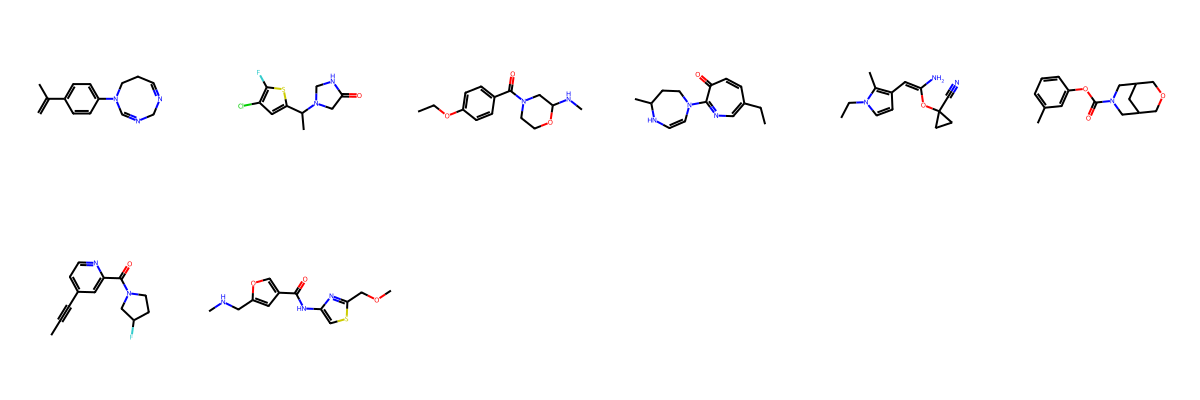

In [37]:
# test generate function and plot generated smiles 
l_seed = test_latent_space[200:201]

print(l_seed)
print(test_set[200:201])
sampling_temperature = 1.25
scale = 0.5
quantity = 15
t_gen_mols, t_gen_smiles = generate(l_seed, sampling_temperature, scale, quantity)

print(f'Sampled smiles:\n {t_gen_smiles}')

Draw.MolsToGridImage(t_gen_mols, molsPerRow=6)


In [41]:
# Take out any 500 smiles from test set to generate molecules 

novo_test_set = test_set[500:1000]
print(novo_test_set)
# Vectorize test set smile
X, _ = vectorize(novo_test_set, 101, n_feature)

# Vectorized test data into the latent space
novo_test_latent_space = encoder_model.predict(X)
print(f'Test set latent space shape: {novo_test_latent_space.shape}')

novo_test_latent_space[0]

['CCN(CC(=O)c1cc(C)sc1C)CC(F)(F)F' 'CCOCC(=O)Nc1cc(C(F)(F)F)ccc1N1CCCCC1'
 'O=C(Cn1cncn1)NCCOc1ccc(Cl)cc1'
 'O=C(c1ccc(Cn2cccc2)cc1)N1CCCC(n2cccn2)C1'
 'O=C1CCCN1c1ccc(NCc2ccccc2Br)cc1'
 'CCn1c(CCNC(=O)c2ccc(OC)cc2C)nc2cccnc21'
 'Cc1ccccc1-c1noc(C(=O)N2CCOCC2)c1N' 'Cc1ccc(CC(=O)C(C#N)c2ccccn2)s1'
 'CCC(=O)N1CCCC(C(=O)N2CCCCC2C(N)=O)C1'
 'COc1ccc(Cl)cc1N(C)C(=O)c1cccc2c1OCC(=O)N2'
 'CC(C)(C)n1cc(NC(=O)Nc2ccc3c(c2)NC(=O)CS3)cn1'
 'Cc1ccccc1C(=O)N1CCC(NS(C)(=O)=O)CC1'
 'Cc1csc(=O)n1CCC(=O)Oc1ccc(NC(=O)C2CC2)cc1'
 'CCOc1ccc(CCC(=O)NCC2CN(C)CCO2)cc1' 'CCCOc1ccc(CN2CCC3(C2)OCCO3)cc1OCC'
 'Brc1ccc(-c2cnc3nccn3c2)cc1'
 'COc1ccc(S(=O)(=O)CC(=O)N2CCNC(=O)C2(C)C)cc1'
 'O=C1N(Cc2ccccn2)CCC12CCN(c1ncc(F)cn1)CC2'
 'Cc1nc(-c2cccc(CNC(=O)c3oc(C)nc3C)c2)n[nH]1'
 'COc1ccc(OC)c(C(=O)N2CCCCC2C2OCCO2)c1' 'O=C(NCc1cscn1)c1csc(-c2ccccc2)n1'
 'CCOc1cccc(NC(=O)N(C)Cc2cc(C(=O)OC)c(C)o2)c1'
 'COCC(=O)N1CCN(Cc2csc(-c3ccc(C)cc3)n2)CC1'
 'CC(Oc1ccccc1Br)C(=O)NCCC1CCCO1' 'Cc1cc(C(=O)Nc2nc3c(C)cccc3s2)on1'
 'CCOc1ccc

array([0.0000000e+00, 4.2910427e-01, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 2.0050936e+00, 7.8472957e-02, 2.5182400e+00,
       0.0000000e+00, 0.0000000e+00, 8.6065555e-01, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.4682242e-01,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 9.6780980e-01, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 2.0852139e+00, 1.3424456e-03,
       0.0000000e+00, 0.0000000e+00, 6.9270986e-01, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 9.1740537e-01, 1.7279783e+00,
       0.0000000e+00, 0.0000000e+00, 2.7278953e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.4560942e-01, 4.8949513e-01, 3.2190409e+00, 1.2506886e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [42]:
# generate molecules based off our sampling dataset's latent space
gen_mols, gen_smiles = [], []
for i in range(novo_test_set.shape[0] - 1):
  latent_seed = novo_test_latent_space[i:i+1]
  sampling_temp = rn.uniform(1.0, 2.5)
  scale = 0.5
  quantity = 20
  mols, smiles = generate(latent_seed, sampling_temp, scale, quantity)
  gen_mols.extend(mols)
  gen_smiles.extend(smiles)
  moles, smiles = [], []
print('SMILES generation completed!')

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 16ms/step
SMILES generation completed!


In [43]:
print(f'Number of generated molecules: {len(gen_mols)}')
print(f'Number of generated smiles: {len(gen_smiles)}')
print(f'Generated SMILES:\n {gen_smiles}')

Number of generated molecules: 3228
Number of generated smiles: 3228
Generated SMILES:
 ['CC(NCC(=O)c1ccc(C#N)c(Cl)c(=O)c1)C', 'CCN(CC(=C)Nc1cc(C)cc(CC)c1C)CO', 'CC(NC(=O)NCC(C)C)Cc1ccsc1CN', 'CC(N)Cc1csc(OC(=O)CC=CC(=O)O)c1', 'CC(NC(=O)c1csc(SCCCc2csc(C)n2)c1)C', 'CCN(Cc1ccc(C#N)c(=C)cc1)C(C)C', 'CC(O)(CNc1cc(C)ccc1C)C(C)Br', 'CC#Cc1ncc(S(C)C)c(-c2cccn2C)c1CCC', 'COCCC(=O)Nc1c(C(C)=O)cccc1N1CCCCC1', 'COCCCNC(C)C(=O)c1c(F)ccc2c1OCCCO2', 'CCNC(C)c1csc(NC(=O)c2cccc(=O)s2)c1C', 'CC#CC(=O)c1cc(OC(N)=O)ccc1-c1nccc(Cl)c1', 'COC(C)C(=O)Nc1ccc(NCCc2ccco2)nc1CCC#N', 'C=CCCNc1cc(=CC(=C)C)[nH]cc1C1=CCCC1', 'CCNC(=O)Cc1cc(S(=O)(=O)CCc2ccnc3sccc23)cs1', 'O=C(Cc1ncncn1)NCCC1c2cc(F)ccc21', 'O=C(Cn1ccnc1S(=O)Cc1F)OCCC1', 'NC1(Nc2cncn(Cc3ccccc3)c2=C)CC1', 'N#Cc1nccn(CN(Cc2ccccc2)C)c1=O', 'O=C(CNc1cncn1OC(F)F)C1cCc2sccc2C1', 'OC(=O)Nc1ccn(C2(Cc3cccs3)CC2)c1', 'O=C(CSc1ccnc(N2CCCC2)c1)CCl', 'OC(C(=O)n1[nH]c(-n2cccc2)c2Cl)cc21', 'OC(c1ccc(-c2ccn[cH]c2)cc1)OC(C1CC1)c1cncnc1', 'O=C(Nc1ccc(-n2cccc2)cc1)N1CCC

In [44]:
# save the generated smiles list
gen_file = '/drive/My Drive/next_gen_data/generated_smiles_14_12.csv'
with open(gen_file, 'w') as f:
    for smi in gen_smiles:
        f.write(smi + '\n')
print('SMILES saved')

SMILES saved
